<a href="https://colab.research.google.com/github/PWhiddy/jax-experiments/blob/main/nbody.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.numpy as jnp
from jax import jit
from jax import vmap
import jax
from numpy import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
!pip install tensor-canvas

In [3]:
import tensorcanvas as tc

In [4]:
#@title VideoWriter
#VideoWriter from Alexander Mordvintsev 
#https://colab.research.google.com/github/znah/notebooks/blob/master/external_colab_snippets.ipynb

import os
import numpy as np
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

In [5]:
def draw_sim(parts_pos, parts_vel, grid_r, opacity=1.0, p_size=4.0):
  canvas = jnp.zeros((grid_r, grid_r, 3))
  col = opacity*jnp.array([1.0,0.0,0.0])
  # would be interesting to use jax.experimental.loops for these
  for part_p, part_v in zip(parts_pos, parts_vel):
    canvas = tc.draw_circle(part_p[0]*grid_r, part_p[1]*grid_r, p_size, col, canvas)
  return canvas

In [6]:
def draw_sim_par(parts_pos, parts_vel, grid_r, opacity=1.0, p_size=4.0):
  col = opacity*jnp.array([1.0,0.0,0.0])
  draw_single = lambda part_p, canv: tc.draw_circle(part_p[0]*grid_r, part_p[1]*grid_r, p_size, col, canv)
  draw_all = vmap(draw_single)
  return draw_all(parts_pos, jnp.zeros((parts_pos.shape[0], grid_r, grid_r, 3))).sum(0)

In [7]:
def compute_forces(pos, scale, eps=0.1):
  a, b = jnp.expand_dims(pos, 1), jnp.expand_dims(pos, 0)
  diff = a - b
  dist = (diff * diff).sum(axis=-1) ** 0.5
  dist = jnp.expand_dims(dist, 2)
  force = diff / ((dist * scale) ** 3 + eps)
  return force.sum(0)

fast_compute_forces = jit(compute_forces)

In [8]:
def sim_update_force(parts_pos, parts_vel, t_delta=0.05, scale=5, repel_mag=0.1, center_mag=2.5, steps=10, damp=0.99):
  p_p = jnp.array(parts_pos)
  p_v = jnp.array(parts_vel)
  # jax.experimental.loops
  for _ in range(steps):
    p_p = p_p + t_delta * p_v
    force = fast_compute_forces(p_p, scale)
    center_diff = p_p-0.5
    centering_force = center_diff / ((center_diff ** 2).sum() ** 0.5)
    p_v = damp * p_v - t_delta * (force * repel_mag + centering_force * center_mag)
  return p_p, p_v

In [9]:
def make_init_state(p_count):
  return random.rand(p_count, 2), random.rand(p_count, 2)-0.5

In [10]:
fast_draw = jit(draw_sim, static_argnums=(2,))
fast_draw_par = jit(draw_sim_par, static_argnums=(2,))
fast_sim_update_force = jit(sim_update_force, static_argnames=('steps'))

100%|██████████| 1000/1000 [00:01<00:00, 690.59it/s]


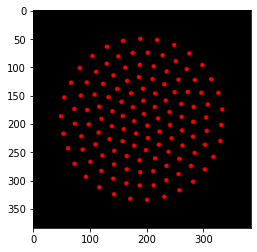

In [11]:
p_state, v_state = make_init_state(128)
v_state *= 0
grid_res = 384
for i in tqdm(range(1000)):
  p_state, v_state = fast_sim_update_force(p_state, v_state, t_delta=0.05, scale=10, center_mag=0.5, repel_mag=0.05, damp=0.996, steps=2)
plt.imshow(fast_draw_par(p_state, v_state, grid_res, p_size=4.0))

100%|██████████| 100/100 [00:03<00:00, 28.72it/s]


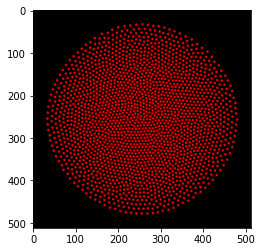

In [12]:
p_state, v_state = make_init_state(2048)
v_state *= 0
grid_res = 512
for i in tqdm(range(100)):
  p_state, v_state = fast_sim_update_force(p_state, v_state, t_delta=0.05, scale=40, center_mag=0.5, repel_mag=0.05, damp=0.997, steps=20)
plt.imshow(fast_draw_par(p_state, v_state, grid_res, p_size=3.0))


In [13]:
render_video = False

In [14]:
if render_video:
  p_state, v_state = make_init_state(128)
  v_state *= 0
  grid_res = 384
  with VideoWriter(fps=60) as vw:
    for i in tqdm(range(1000)):
        render = fast_draw_par(p_state, v_state, grid_res, p_size=3.0)
        vw.add(render)
        p_state, v_state = fast_sim_update_force(p_state, v_state, t_delta=0.05, scale=10, center_mag=0.5, repel_mag=0.05, damp=0.996, steps=2)

In [15]:
if render_video:
  p_state, v_state = make_init_state(512)
  v_state *= 0
  grid_res = 256
  with VideoWriter(fps=60) as vw:
    for i in tqdm(range(1000)):
        render = fast_draw_par(p_state, v_state, grid_res, opacity=0.5, p_size=3.0)
        vw.add(render)
        p_state, v_state = fast_sim_update_force(p_state, v_state, t_delta=0.05, scale=20, center_mag=0.5, repel_mag=0.05, damp=0.998, steps=4)

In [16]:
!nvidia-smi

Mon Sep 13 07:48:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    66W / 149W |  10306MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
p_test = 50
res_test = 512

In [18]:
%%timeit
draw_sim(*make_init_state(p_test), res_test)

1 loop, best of 5: 647 ms per loop


In [19]:
%%timeit
draw_sim_par(*make_init_state(p_test), res_test)

The slowest run took 67.17 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 31.3 ms per loop


In [20]:
%%timeit
fast_draw(*make_init_state(p_test), res_test)

The slowest run took 15879.49 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 243 µs per loop


In [21]:
%%timeit
fast_draw_par(*make_init_state(p_test), res_test)

The slowest run took 1280.06 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 240 µs per loop
